# Group 1 - Project Report 

*By Sylvia Ying, Xiaolei Lin, and Erin Kang*

## Introduction
Attending university is an important stage of one’s academic journey. However, not every student obtains a degree, in which their dropout can be caused by a variety of factors. Predicting chances for academic success can be vital for the future of both the student and university in considering whether the student should continue their studies. The dataset “Predict students' dropout and academic success” contains different factors, such as students’ gender and grades, that may contribute towards students’ status of becoming a graduate or a dropout. 

Grades were measured from 0 to 20, where 20 indicates 100%, and grades between 0 to 50 were not given. Hence, students were  either given a grade of 0 or a grade higher or equal to 10 (50%).   Using this dataset, the goal is to see if students’ gender, age at enrollment, first year’s first and second semester grades are collectively a good predictor in determining the academic status of university students (graduate or dropout).  

## Process

We loaded the necessary packages for our analysis.  

In [2]:
library(tidyverse)
library(tidymodels)
library(ggplot2)
library(cowplot)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

We read the data into R and tidied and wrangled it by converting the ‘Target’ vector to a factor from a character, choosing only the predictors of interest, and renaming them into more human-readable forms. 

In [3]:
data_set<- read_csv("https://raw.githubusercontent.com/ekang27kc/dsci100-2023-T2-Group01-project/main/dataset.csv")
my_data <- data_set |> 
    select(`Gender`, `Age at enrollment`, `Curricular units 1st sem (grade)`, 
           `Curricular units 2nd sem (grade)`, `Target`) |>
    filter(Target != "Enrolled") |>
    mutate(Target = factor(Target, levels = c("Dropout", "Graduate")))
colnames(my_data) <- c('gender', 'enrollment_age', 'first_semester_grade', 'second_semester_grade', 'status') # rename

head(my_data)

Rows: 4424 Columns: 35
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Target
dbl (34): Marital status, Application mode, Application order, Course, Dayti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,enrollment_age,first_semester_grade,second_semester_grade,status
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,20,0.00000,0.00000,Dropout
1,19,14.00000,13.66667,Graduate
1,19,0.00000,0.00000,Dropout
0,20,13.42857,12.40000,Graduate
0,45,12.33333,13.00000,Graduate
1,50,11.85714,11.50000,Graduate


_<span style="color:gray">**Table 1:** Tidied and wrangled dataframe of “Predict students' dropout and academic success” dataset.</span>_

We set the seed for the analysis to be reproducible, and split the tidied data set into a training and testing dataset. 

In [4]:
set.seed(1)

# split data, create training data and testing data
data_split <- initial_split(my_data, prop = 0.75, strata = status)
data_train <- training(data_split)   
data_test <- testing(data_split)

### Preliminary Analysis

In [5]:
summary_table <- data_train |>
    group_by(status) |>
    summarize(status_count = n(),
              female_count = sum(gender == 0),
              male_count = sum(gender == 1),
              mean_enrollment_age = mean(enrollment_age, na.rm = TRUE),
              mean_first_semester_grade = mean(first_semester_grade, na.rm = TRUE),
              mean_second_semester_grade = mean(second_semester_grade, na.rm = TRUE),
              missing_data = sum(is.na(enrollment_age), is.na(first_semester_grade), is.na(second_semester_grade)))
summary_table

status,status_count,female_count,male_count,mean_enrollment_age,mean_first_semester_grade,mean_second_semester_grade,missing_data
<fct>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
Dropout,1065,547,518,26.15681,7.328979,5.812974,0
Graduate,1656,1229,427,21.76208,12.594641,12.635296,0


_<span style="color:gray">**Table 2:** General statistical information about dataset.</span>_

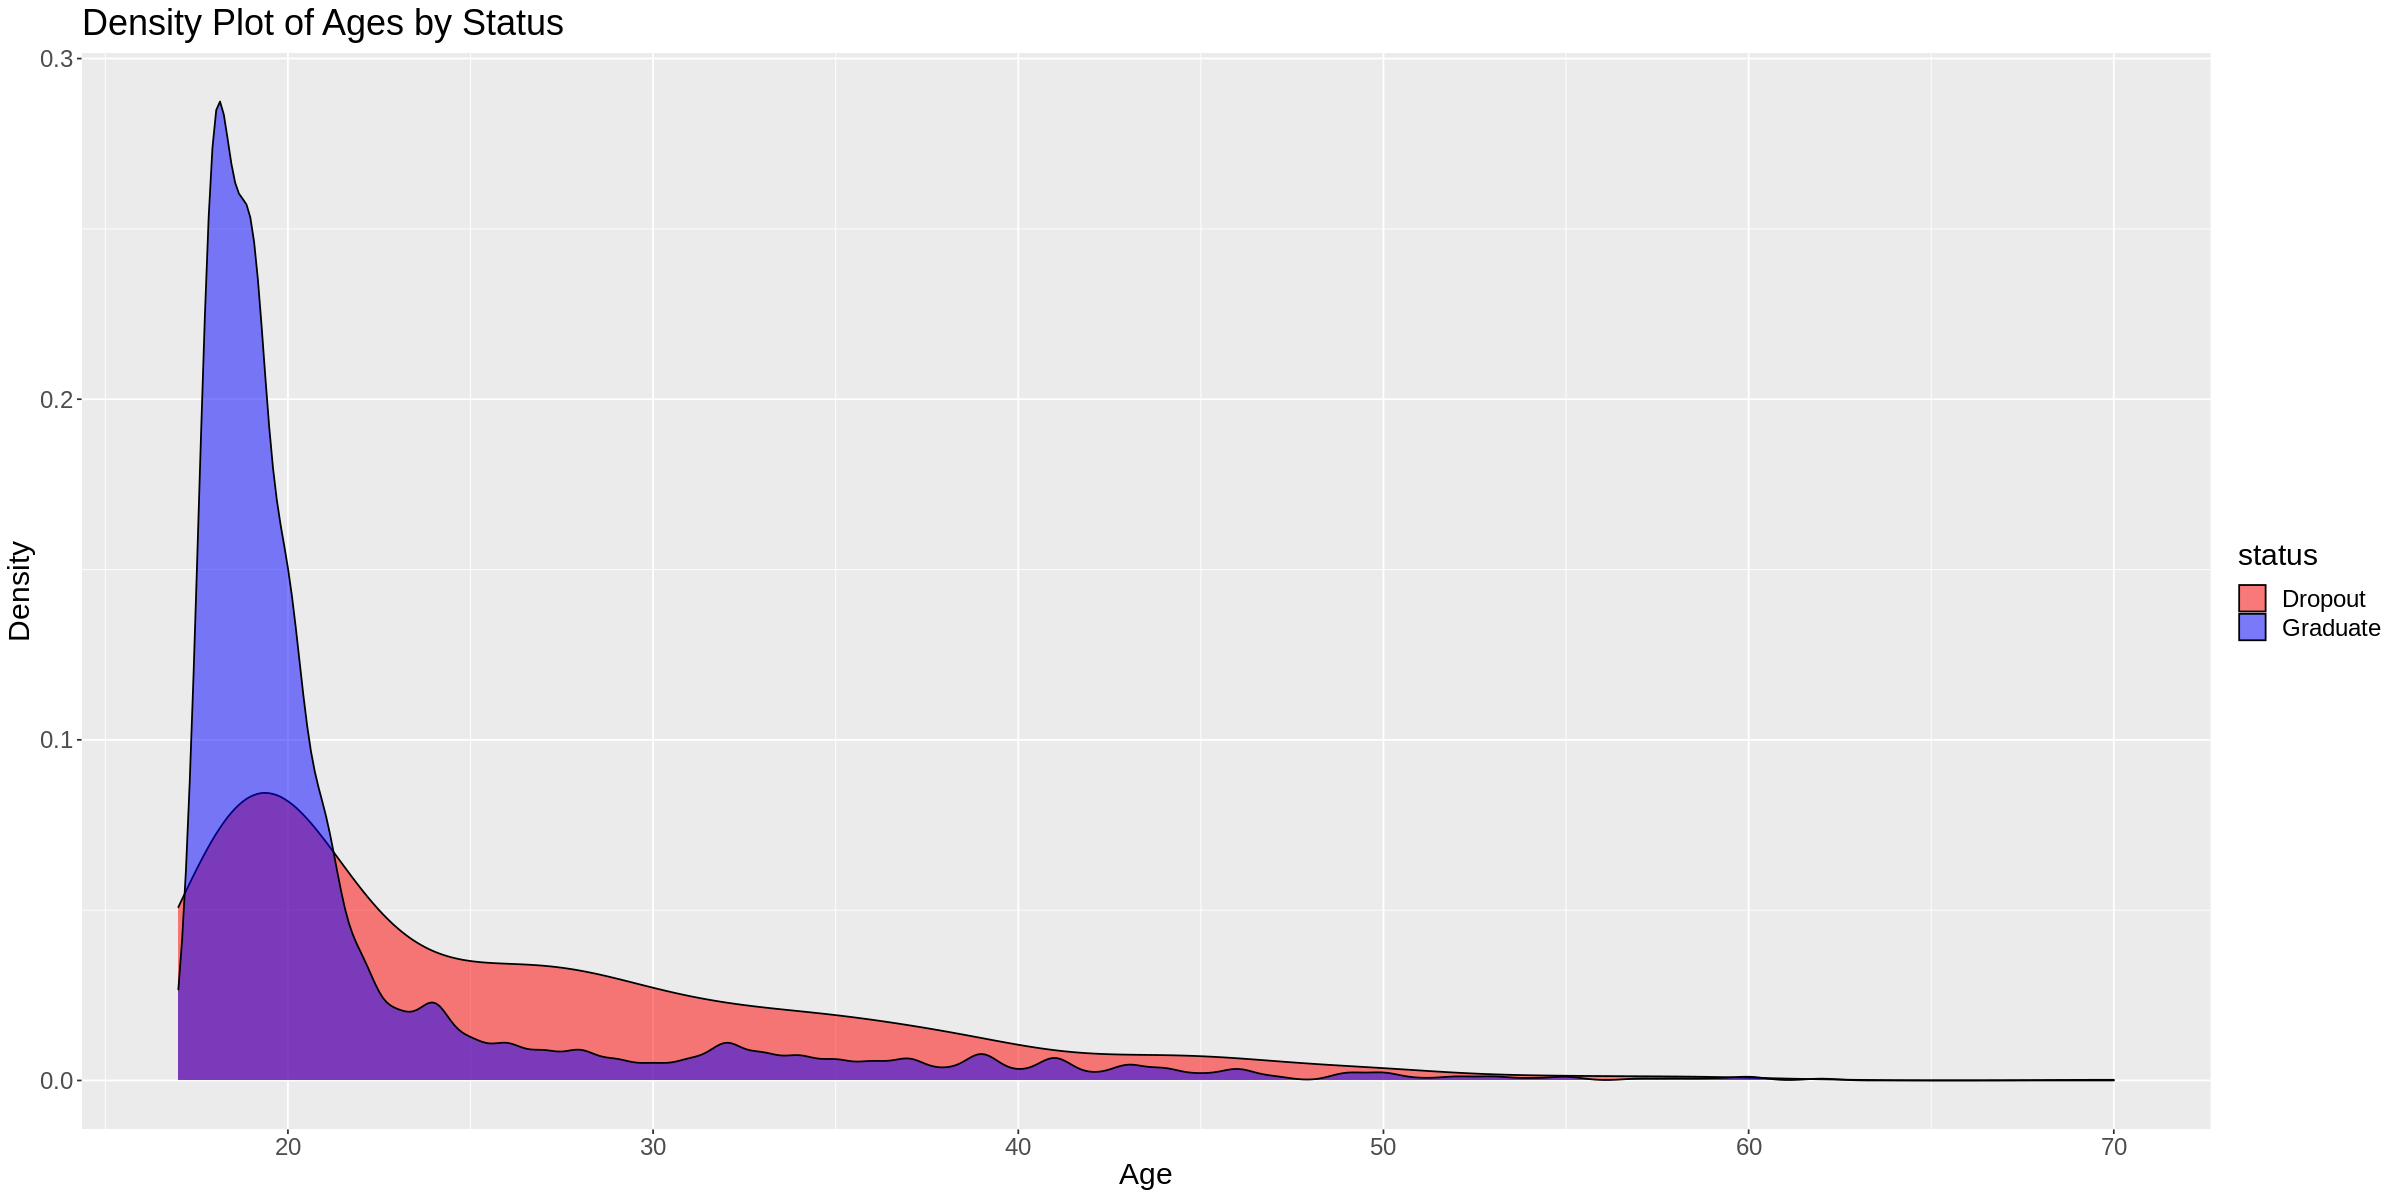

In [6]:
options(repr.plot.width = 20, repr.plot.height = 10)

density_plot <- ggplot(data_train, aes(x = enrollment_age, fill = status)) + 
  geom_density(alpha = 0.5) +
  scale_fill_manual(values = c("red", "blue")) +
  labs(title = "Density Plot of Ages by Status", x = "Age", y = "Density") +
  theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

density_plot

<span style="color:gray">**Figure 1:** Density plot of enrollment age and status (dropout or graduate). </span>
<br>The density plot shows that the majority of students in the dataset are in their 20s, as this age group has the highest density of observations. The plot shows that the dropout is signifcantly less when individuals are in their late 10s and early 20s. The difference in density between dropouts and graduates decreases significanlty as age increases, indicating that age is linked to decreasing the chances of being a graduate. 

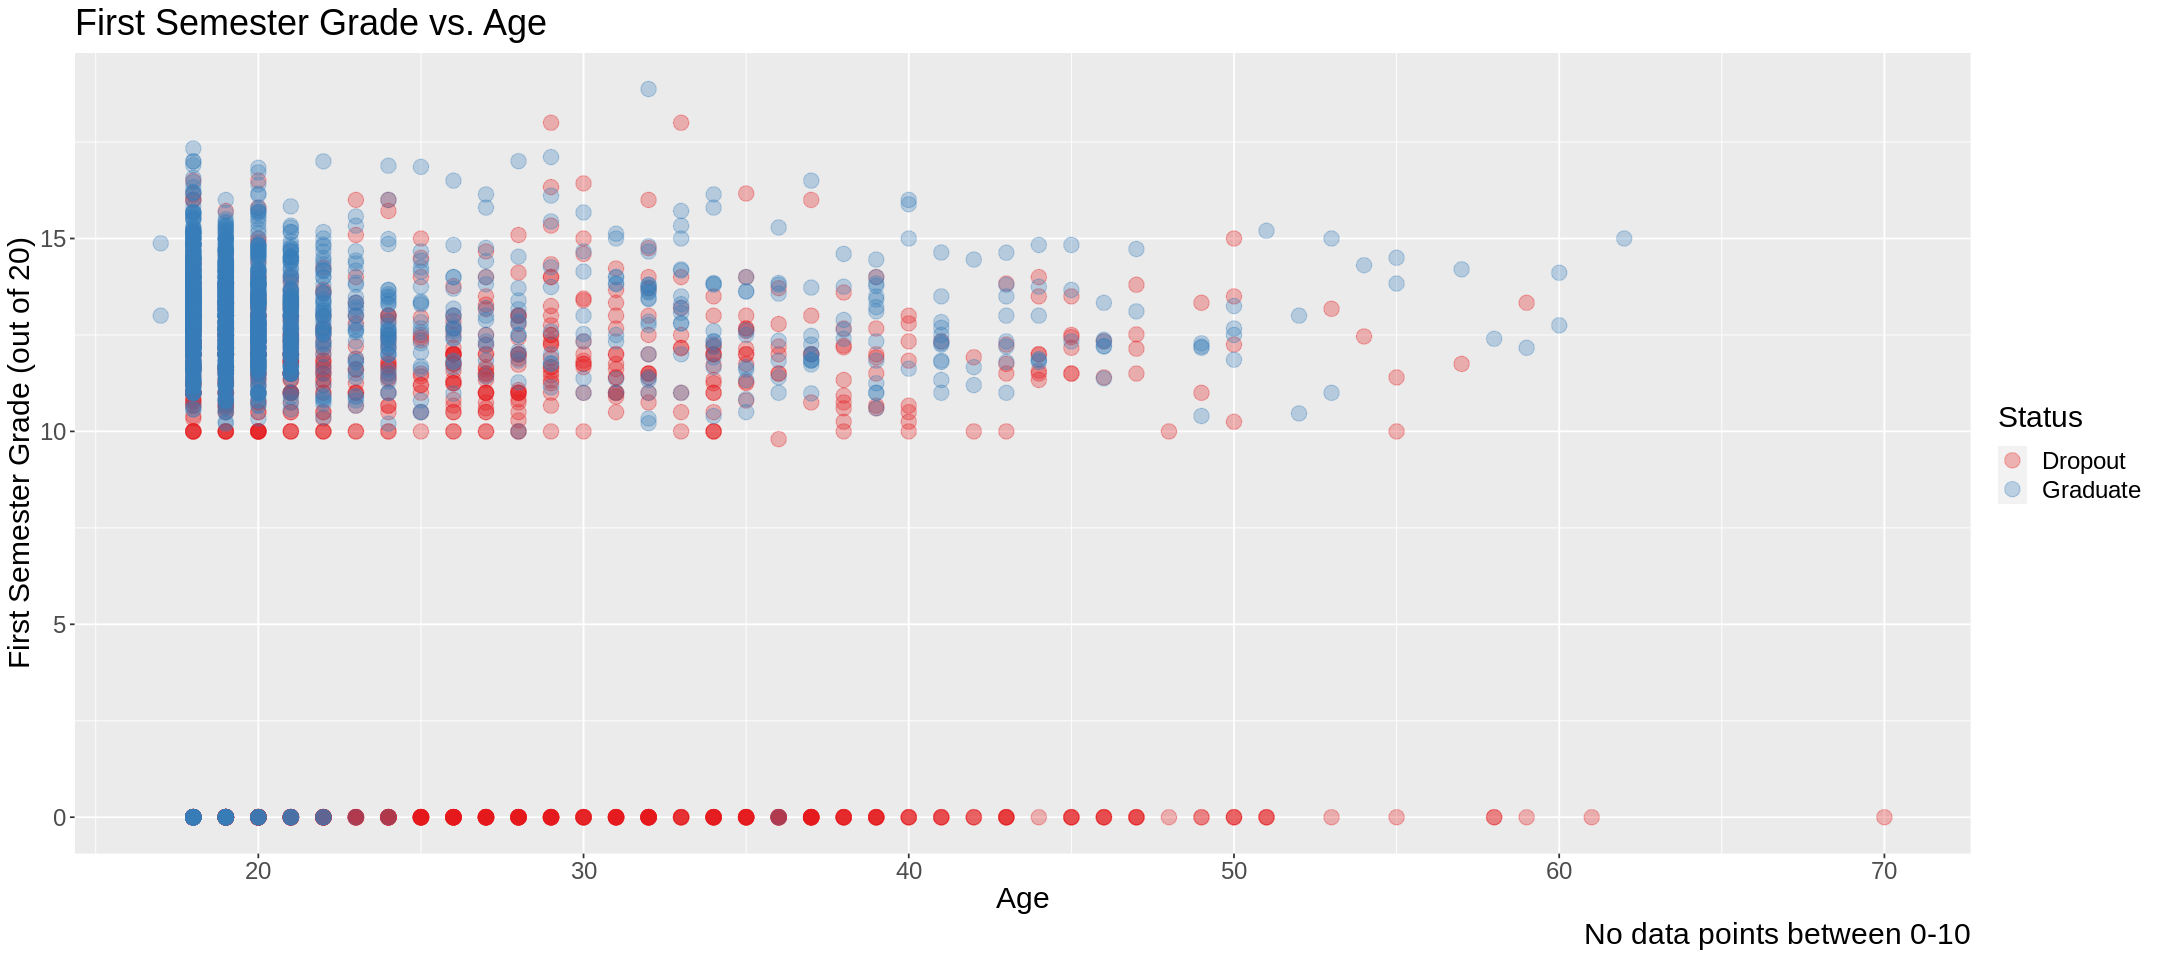

In [11]:
options(repr.plot.width = 18, repr.plot.height = 8)

plot_one <- ggplot(data_train,
                   aes(x = enrollment_age, y = first_semester_grade, colour = status)) +
                           geom_point(alpha = 0.3, size = 4) +
                           labs(x = "Age", y = "First Semester Grade (out of 20)", title = "First Semester Grade vs. Age",
                                colour = "Status", caption = "No data points between 0-10") +
                           scale_color_brewer(palette = "Set1")+
                           theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

plot_one

<span style="color:gray">**Figure 2:** The relationship between enrollment age and first semester grade by academic status.</span>\
It is more likely to graduate when enrolled at a young age of the 20s, as red dots (dropouts) begin to apear more when passed that age and appear the most at the age of late 20s to 30s. It seems that students in their early 20s who receive a grade of zero in the first semester still manage to graduate, while those past the age of around 23 become dropouts.   

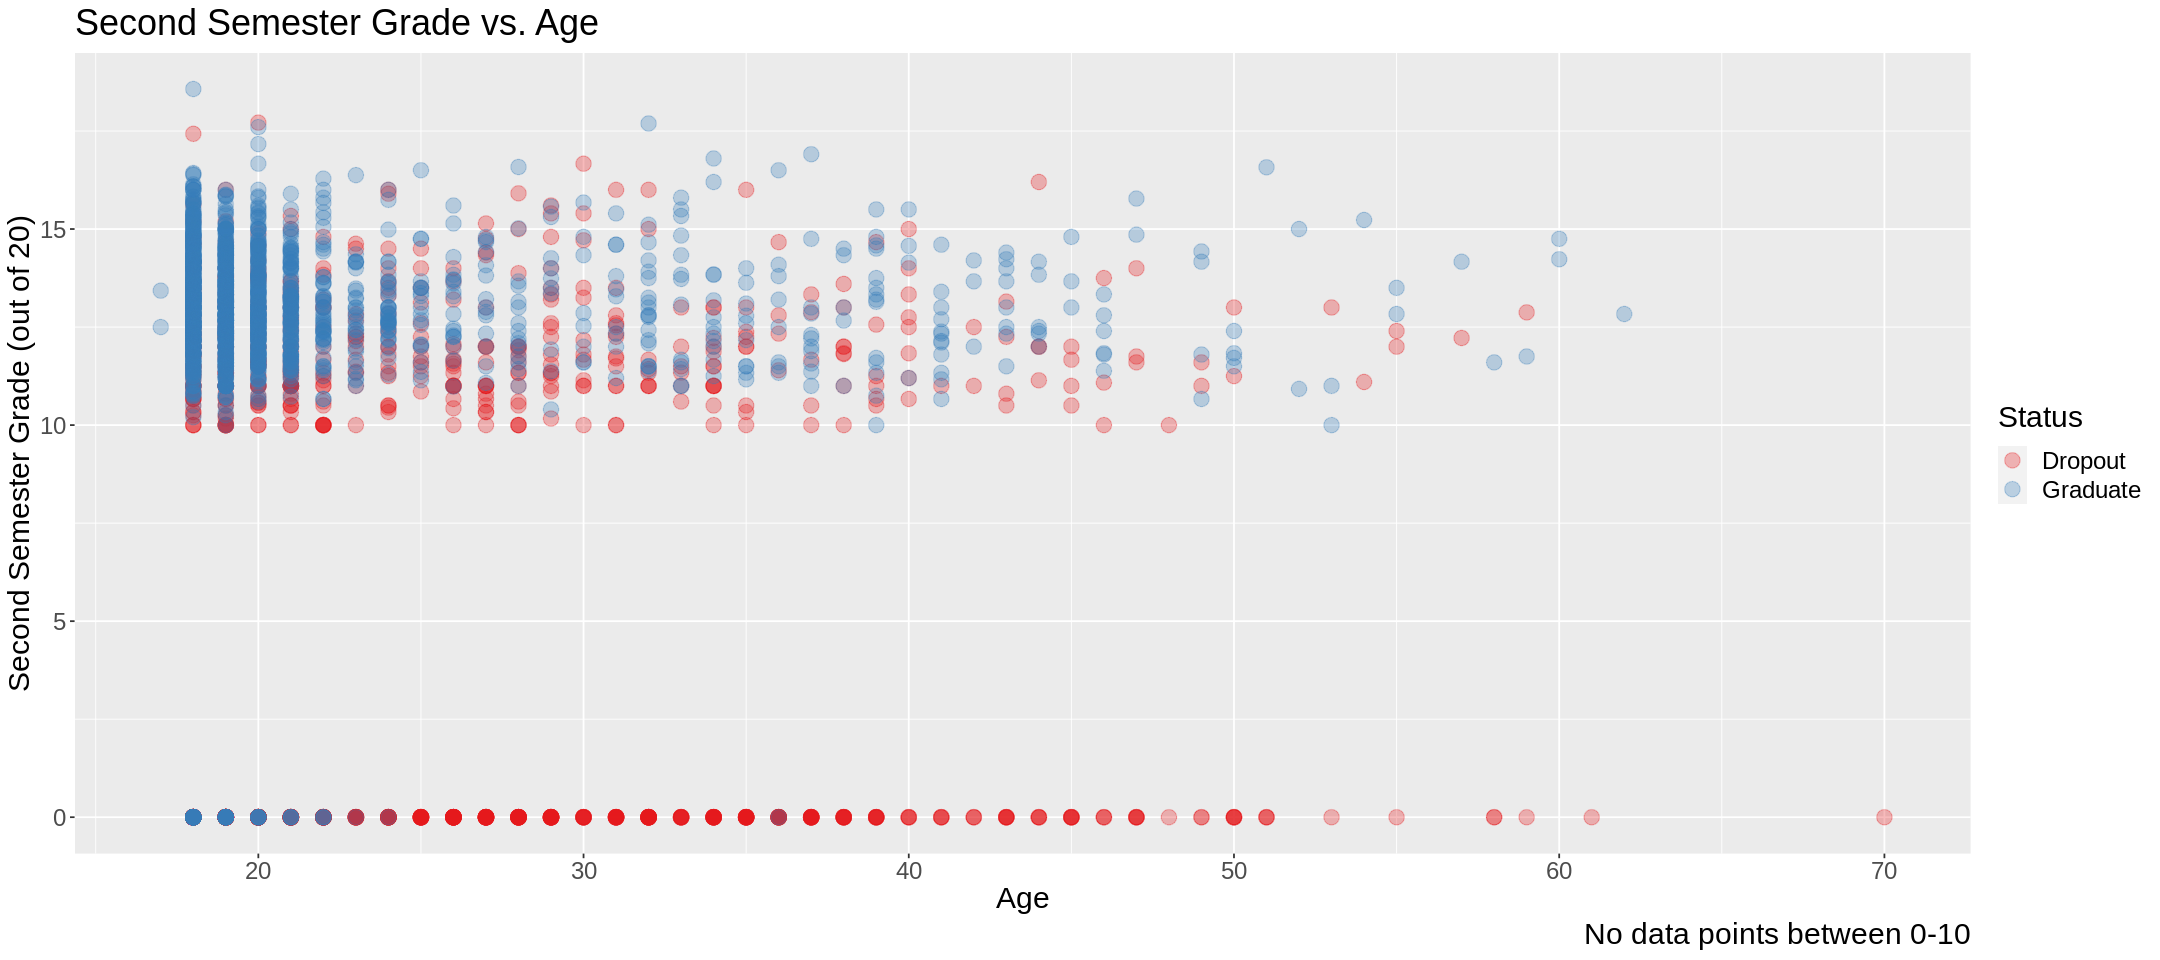

In [26]:
options(repr.plot.width = 18, repr.plot.height = 8)

plot_two <- ggplot(data_train,
                   aes(x = enrollment_age, y = second_semester_grade, colour = status)) +
                           geom_point(alpha = 0.3, size = 4) + 
                           labs(x = "Age", y = "Second Semester Grade (out of 20)", title = "Second Semester Grade vs. Age",
                                colour = "Status", caption = "No data points between 0-10") +
                           scale_color_brewer(palette = "Set1") +
                           theme(text = element_text(size = 18), plot.caption = element_text(size = 18))

plot_two

_<span style="color:gray">**Figure 3:** Relationship between enrollment age and second semester grade by academic status.</span>_ \
Similar to the previous analysis, it is more likely to graduate when enrolled at a young age of the 20s, as red dots (dropouts) apear more when passed that age and appear the most at the age of late 20s to 30s. It seems that students in their early 20s who receive a grade of zero in the first semester still manage to graduate, while those past the age of around 23 become dropouts.   

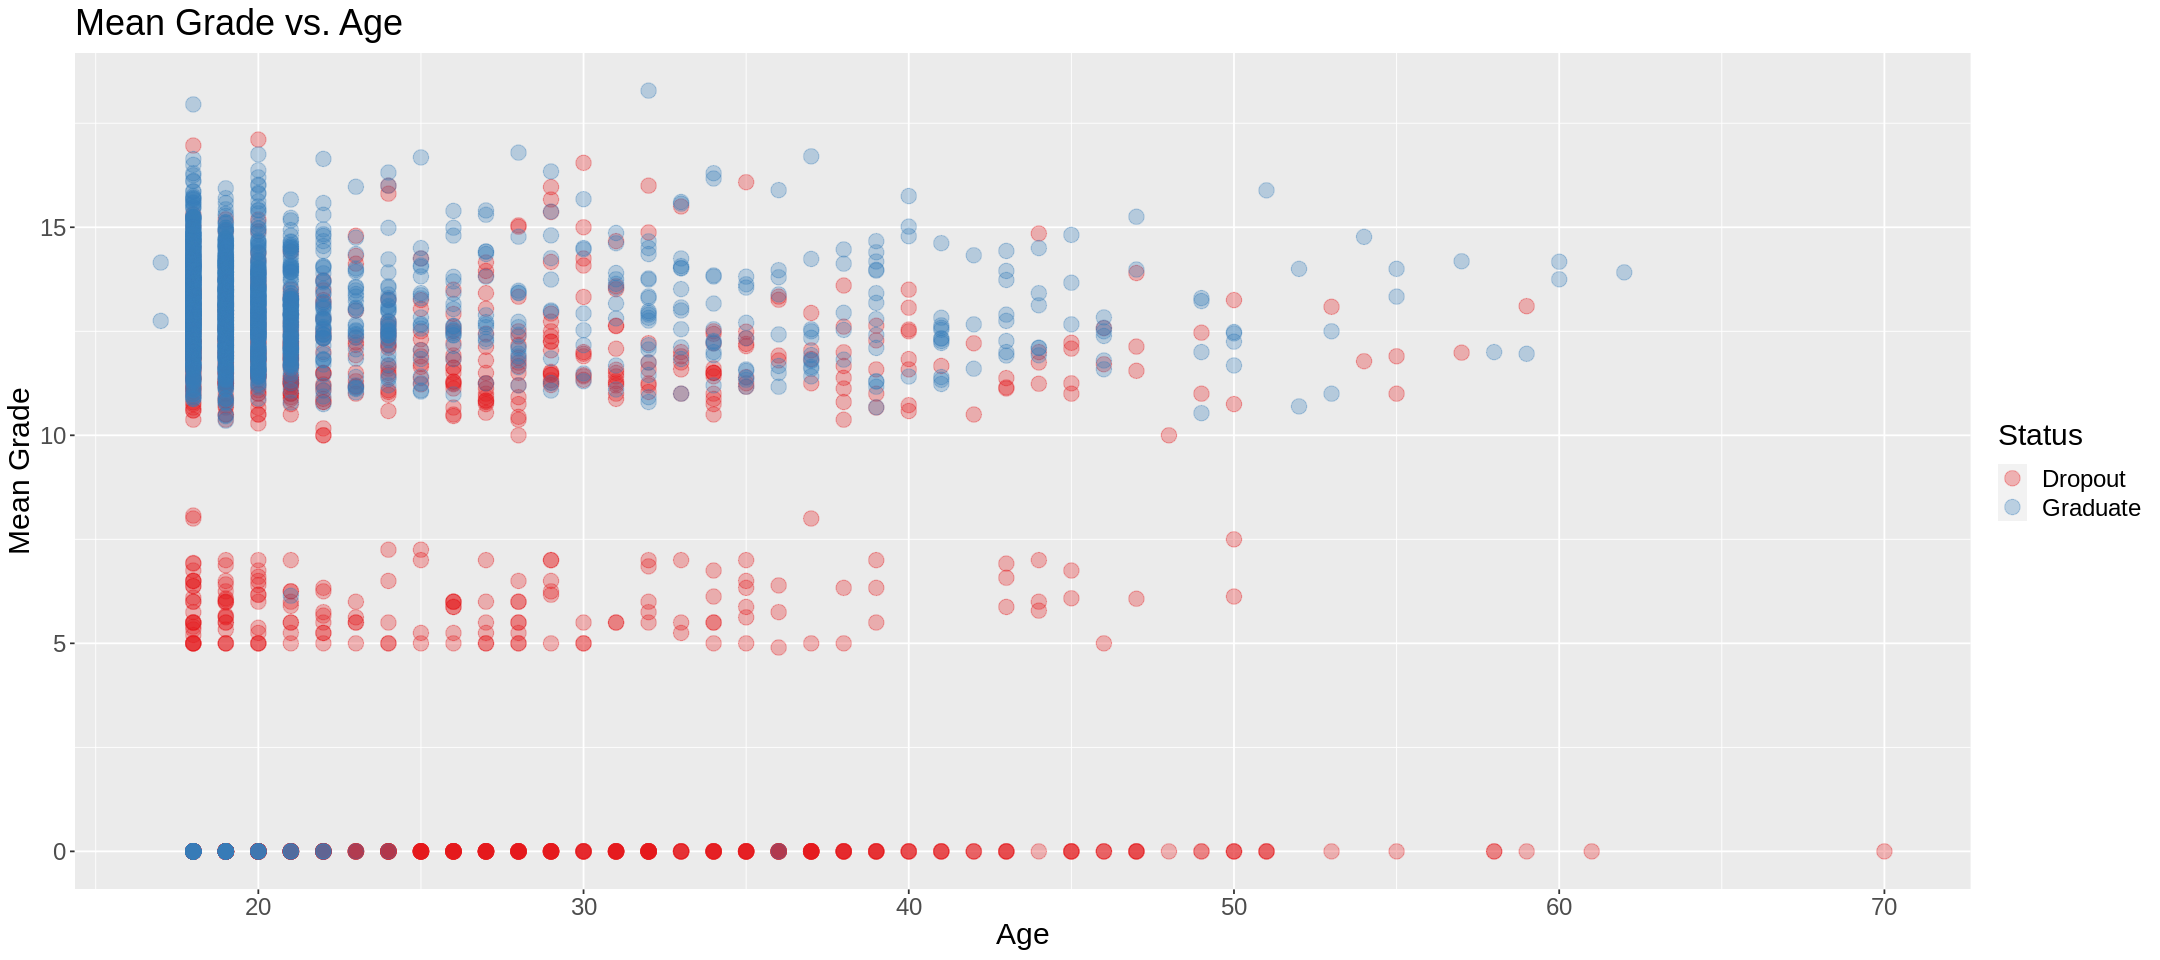

In [27]:
options(repr.plot.width = 18, repr.plot.height = 8)

mean_grade_plot <- data_train |>
    mutate(mean_sem_grade = (first_semester_grade + second_semester_grade) / 2) |>
    ggplot(aes(x = enrollment_age, y = mean_sem_grade, colour = status)) +
    geom_point(alpha = 0.3, size = 4) +
    labs(x = "Age", y = "Mean Grade", title = "Mean Grade vs. Age",
         colour = "Status") +
        scale_color_brewer(palette = "Set1")+
    theme(text = element_text(size = 18))

mean_grade_plot

_<span style="color:gray">**Figure 4:** Relationship between nrollment age and mean first year grade (average of first and second semester grades) by academic status.</span>_ \
`explanation`

In [28]:
zero_grade_count <- data_train |>
  group_by(status) |>
  summarize(first_semester_zero = sum(first_semester_grade == 0),
            second_semester_zero = sum(second_semester_grade == 0))

total_first_semester_zero <- sum(data_train$first_semester_grade == 0)
total_second_semester_zero <- sum(data_train$second_semester_grade == 0)

zero_grade_count <- zero_grade_count |>
  add_row(status = "Total",
          first_semester_zero = total_first_semester_zero,
          second_semester_zero = total_second_semester_zero)

zero_grade_count

status,first_semester_zero,second_semester_zero
<chr>,<int>,<int>
Dropout,420,552
Graduate,64,63
Total,484,615


_<span style=
"color:gray">**Table 3:** The number of students who had a zero grade in the first and second semesters by academic status. </span>_ \
Based on the information in the table, it appears that a large proportion of students who received a zero grade in either the first or second semester ultimately dropped out. This indicates a strong relationship between receiveing a grade of zero and becoming a drop out. Hence, to investigate the relationship of first semester grades, second semester grades, and acadamic status, we created a scatter plot excluding the zero grades since it is known for them to be likely dropouts.

Warning message:
“Removed 631 rows containing missing values (geom_point).”


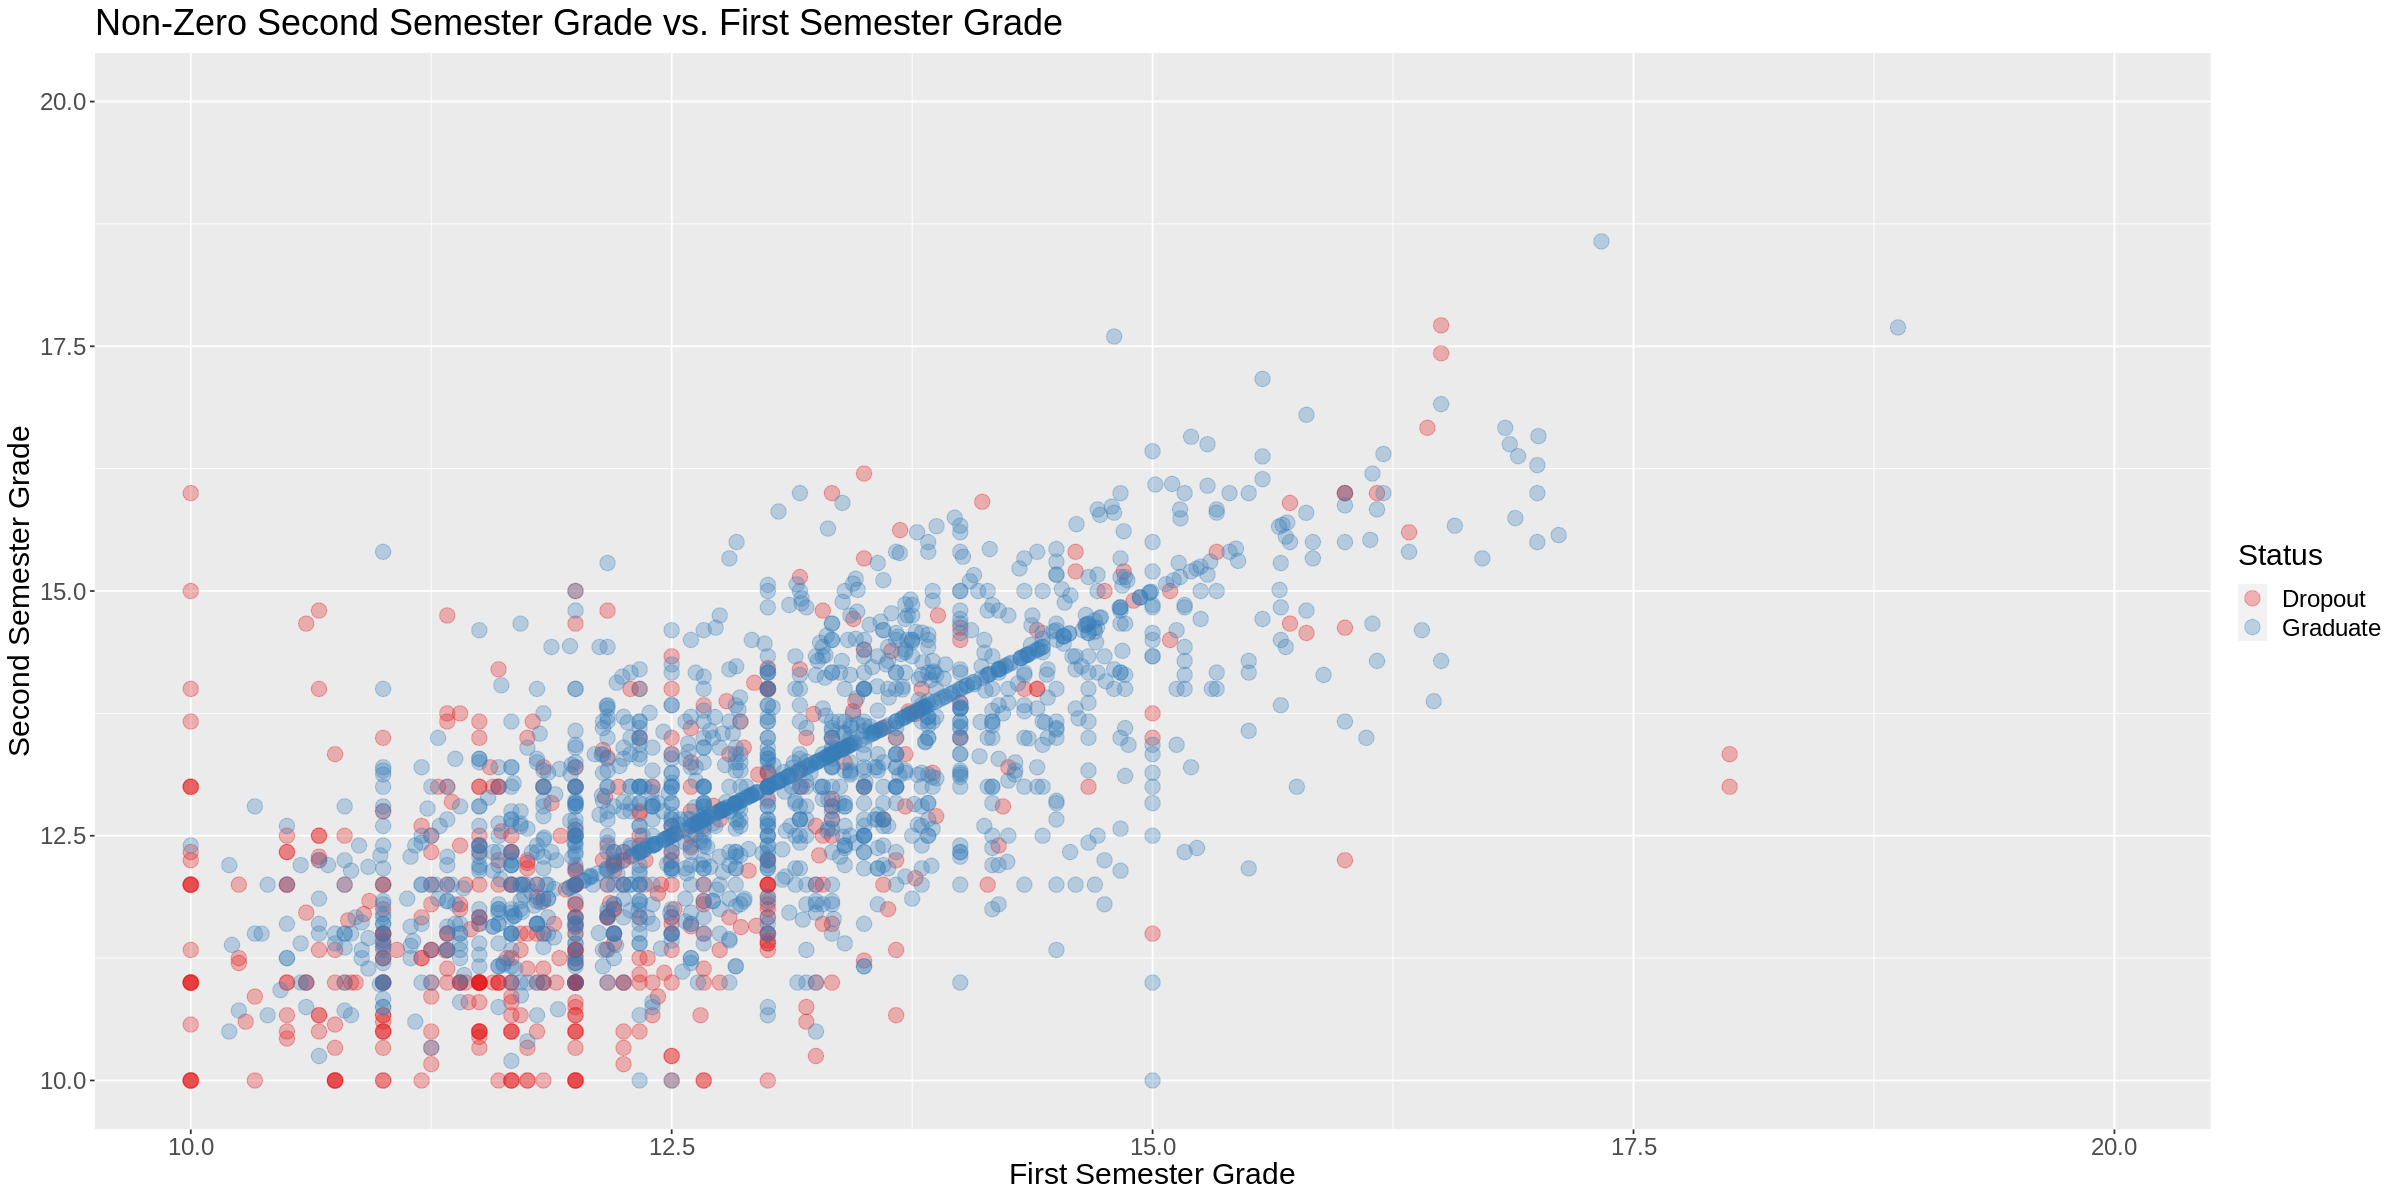

In [34]:
options(repr.plot.width = 20, repr.plot.height = 10)

grade_plot <- data_train |>
    ggplot(aes(x = first_semester_grade, y = second_semester_grade, colour = status)) +
    geom_point(alpha = 0.3, size = 4) +
    labs(x = "First Semester Grade", y = "Second Semester Grade", 
         title = "Non-Zero Second Semester Grade vs. First Semester Grade",
         colour = "Status") +
         ylim(c(10, 20)) +
         xlim(c(10, 20)) +
         scale_color_brewer(palette = "Set1") +
    theme(text = element_text(size = 18))

grade_plot

_<span style="color:gray">**Figure 5:** The relationship between second semester and first semester grades by academic status. </span>_

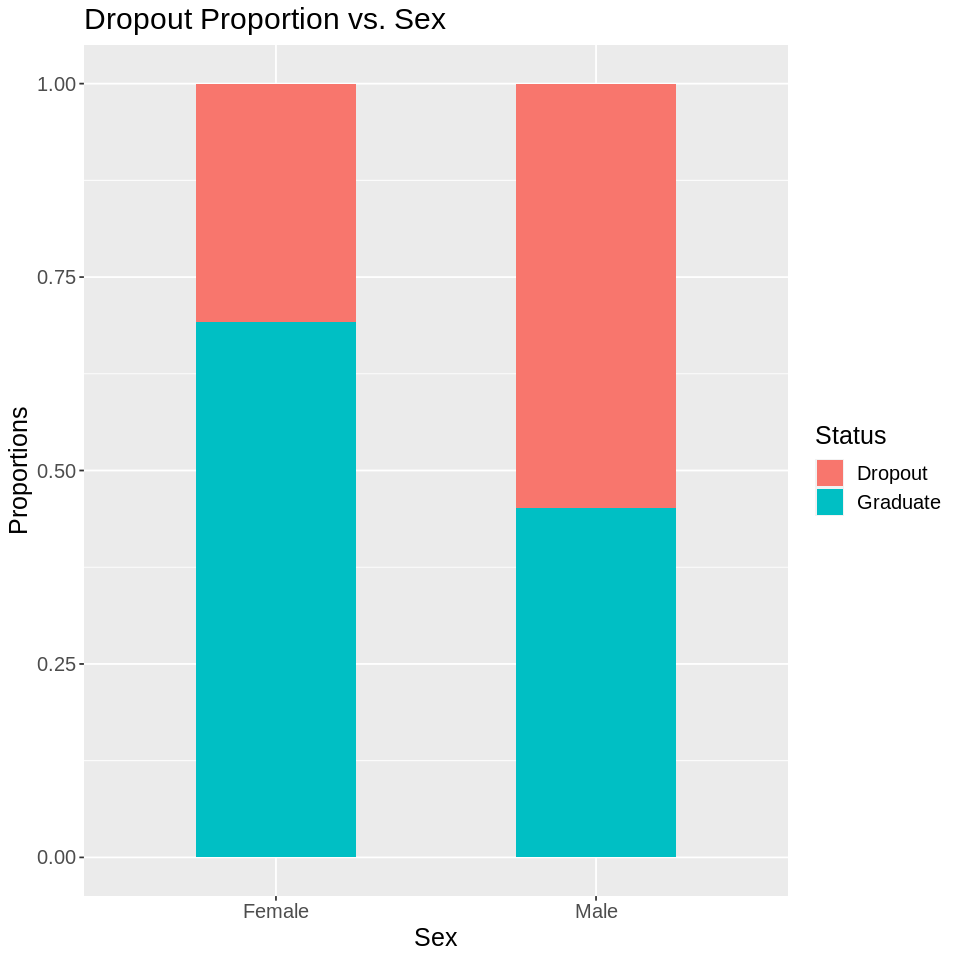

In [12]:
options(repr.plot.width = 8, repr.plot.height = 8)

proportion_bar_plot <- data_train |>
   mutate(gender = factor(gender, levels = c("0", "1"), labels = c("Female", "Male"))) |>
   ggplot(aes(x = gender, fill = status)) + 
   geom_bar(position = 'fill', width = 0.5) + 
   xlab("Sex") +
   ylab("Proportions") +
   labs(fill = "Status") +
   ggtitle("Dropout Proportion vs. Sex") +
   theme(text = element_text(size = 15))

proportion_bar_plot

_<span style="color:gray">**Figure 6:** The types of academic status (dropout and graduate) proportion by gender. </span>_

## Methods
#### Choosing Predictors:
Four characteristics that may predict whether an individual will be a graduate or a dropout were chosen.

##### Gender
Studies have shown that females are more likely to graduate than males.<sup> 1, 2</sup>

##### Age at Enrollment
The opportunity cost for older students is higher and may likely lead to the choice of dropping out than a younger individual.<sup> 3</sup>

##### 1st & 2nd Semester Grades (2 predictors)
Grades could be a predictor, as low grades can result in students choosing to drop out. Changes in grades from first to second semester could also influence students' decision of dropping out.  

The goal is to see if these predictors do indeed predict whether an individual will graduate or drop out and how well it predicts it.

First, we created a recipe, specifying the interested class/label and predictors' columns and standardizing the training dataset by scaling and centering our observation values.

In [10]:
data_recipe <- recipe(status ~ . , data = data_train)|>
step_scale(all_predictors())|>
step_center(all_predictors())

We then made a model specification, telling R to use the K-nearest-neighbor algorithm and tune the model with mulitple different numbers of nearest neighbors (k). 

In [11]:
data_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
set_engine("kknn")|>
set_mode("classification")

We make a 5-fold cross validation for our training dataset to obtain a better estimate of the model's accuracy for each k value used. 

In [12]:
set.seed(1)

data_vfold <- vfold_cv(data_train, v = 5, strata = status)

We created a tibble of all the k values we want the model to try. 

In [40]:
k_vals <- tibble(neighbors = seq(from = 1, to = 200, by = 2))

We created a workflow where the model specification and recipe was fit into each classification model with differnt k values (1-200 by 2s). 

In [23]:
data_fit <- workflow()|>
add_model(data_spec)|>
add_recipe(data_recipe)|>
tune_grid(resamples = data_vfold, grid= k_vals)

We collected the estimated accuracies of each classifier to determine the best number of neighbours used on our model by picking the classifier with the highest estimated accuracy. 

In [25]:
data_accuracies<-data_fit|>
collect_metrics()|>
filter(.metric == "accuracy")

With a dataframe of each classifier's estimated accuracies using differnt k values, we plotted a point-line graph showing the estimated accuracies according to the number of neighbors used. This helped us better visualize each models' accuracy and gave a ballpark of the k value that would result in a model with the highest accuracy.

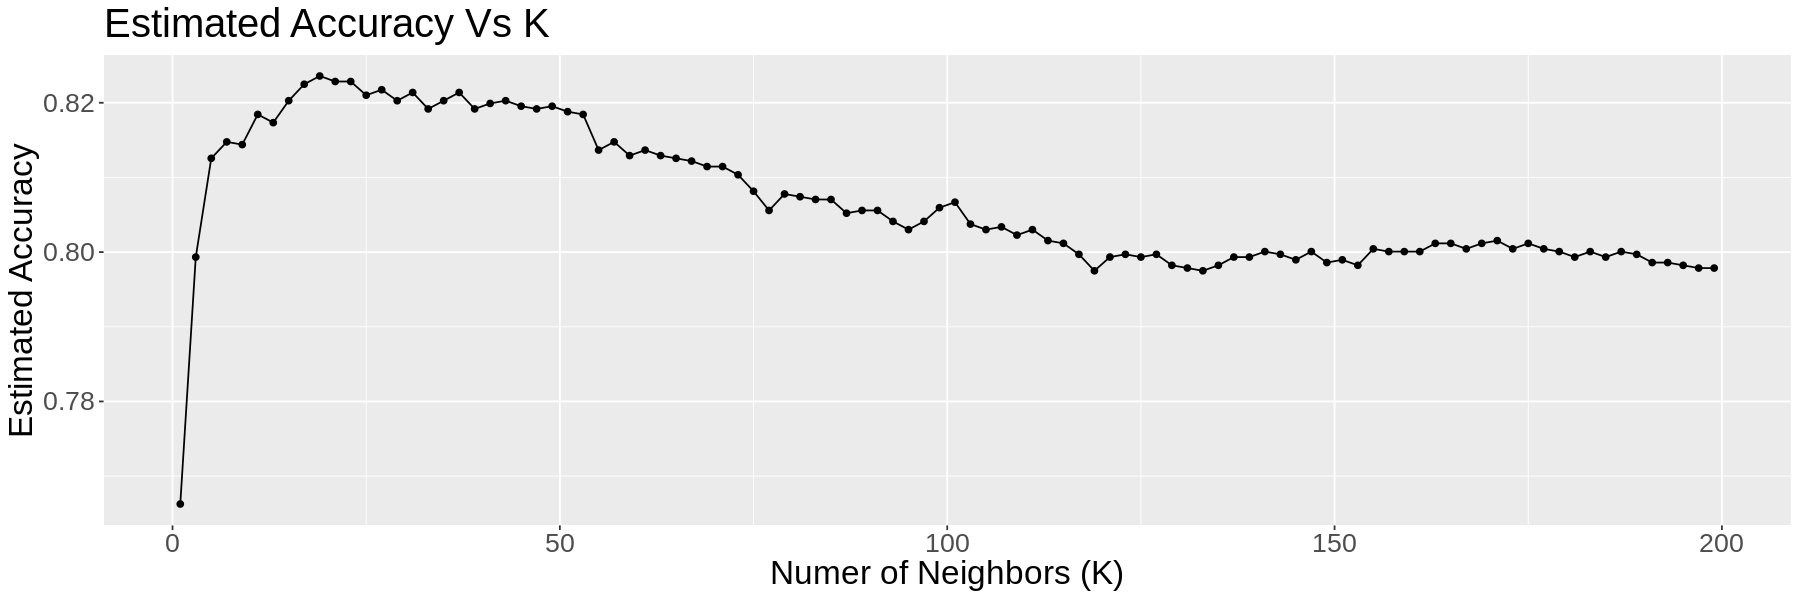

In [38]:
options(repr.plot.width= 15., repr.plot.height=5)

neighbor_accuracy_plot<- ggplot(data_accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Numer of Neighbors (K)", y = "Estimated Accuracy") +
                  ggtitle("Estimated Accuracy Vs K")+
                  theme(text = element_text(size = 20)) 
neighbor_accuracy_plot

_<span style="color:gray">**Figure 6:** Estimated accuracy of the model using K values of 1 to 100 by 2s. The highest peak occured when the k value was around 20.</span>_

We used the accuracy data set and arranged it in descending order by the mean value (estimated accuracy) to select the k value that produced a model with the highest estimated accuracy. We did this by slicing the first row of the dataframe and pulling the neighbor value.  

In [33]:
data_accuracies|> 
arrange(desc(mean))|>
slice(1)|>
pull(neighbors)

[1] 19

The k value that produced the highest estimated accuracy of the classification model was when k=19. 

We retrained our training dataset with the best k value by specifying the KNN algorithm to use 19 closest data points to obtain the highest accuracy model. 

In [35]:
data_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbor = 19)|>
set_engine("kknn")|>
set_mode("classification")

Using the recipe created before and the newly created model specification with the best k value, we created a new workflow to better train our model and enhance our predictions.  

In [18]:
data_best_fit <- workflow()|>
add_model(data_spec_best)|>
add_recipe(data_recipe)|>
fit(data_train)

We test the trained model on our testing dataset to evaluate the performance of the model by obtaining the `status` predictions the model made and the real `status` in the testing data. 

In [36]:
predictions<- predict(data_best_fit, data_test)|>
bind_cols(data_test)

We then collected the model's statistics' accuracy value using `metrics()` to see how accurately/well the model performed.

In [20]:
data_metrics<- predictions|>
metrics(truth = status, estimate = .pred_class)|>
filter(.metric == "accuracy")
data_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8217822


_<span style="color:gray">**Table 3:** Estimated accuracy of the classification model was determined to be 82.18%. </span>_

Finally, we created a confusion matrix to see how many of the predicted values aligned with the actual values from the testing dataset. Using the matrix, We also observed what the model specfically predicted right and wrong based on how many times the model predicted the students' `status` correctly and didn't.

In [21]:
data_conf_mat<- conf_mat(predictions, truth=status, estimate=.pred_class)
data_conf_mat

          Truth
Prediction Dropout Graduate
  Dropout      237       43
  Graduate     119      510

_<span style="color:gray">**Table 4:** A confusion matrix of the model's predictions and the true status showing the kind of predictions the model made and the number of times it predicted correctly and wrongly. </span>_

## Discussion

As shown in Table 3, it was found that our classification model was quite accurate, having an accuracy of 82.18% when tested on our testing data. This is as expected since the chosen predictors are known to be related to whether a student is likely to graduate or drop out. Hence, this classification may be useful for predicting whether or not a student will graduate or become a dropout in the future. 

For students from one perspective, a prediction of being a dropout may motivate an individual in their studies, and others with a prediction of being a graduate may be encouraged to keep up with their work. On the flip side, a dropout status prediction may discourage the individual from trying any harder and nudge them into actually considering dropping out, and a graduate status prediction may reassure individuals enough to prevent them from pushing themselves for reaching a higher grade (if they are content with just graduating). 

For teachers, this classification model may help them note which students may be more difficult to graduate and invest more time and energy into helping them in their studies. 

For universities and other academic institutions, this model can help them identify how many of their students are likely to be graduates and dropouts and plan their courses, programs, and activities accordingly. For example, with a census of how many people are likely to graduate in the coming years, they may start building more on-campus residencies if many are likely many who’ll graduate. 
Another example is when seeing if a student is worth investing their money in schooling. Perhaps a parent wants to see if it’ll be worth their money to send their child for another year of school. 

However, note that the predictor for grades was based only on the first and second semesters of the first year. A lot of changes in grades, both positive and negative, may have occurred after students’ first year till graduation. No matter how accurate our model is, we never know how people change. Hence, we shouldn’t trust the model’s prediction too much and be worry-free when given a graduate status, nor be discouraged and lose hope when given a dropout status.  

Classes with similar ages, grades, and gender based on the predictors could be made if it would be beneficial to the students graduating. 

Based on our analysis, further studies could be done to analyze each factor’s significance (sex, age, grades in first and second semesters) in predicting students' future status and determining why certain factor(s) could be more significant than others. Based on the fairly high accuracy of the model, another question would be whether or not this model can be applied to elementary and high school students. If there is the same trend in the prediction accuracy in elementary and high schools as in universities, one could also ask when the prediction is most accurate to see how the chosen factors have different effects and degrees of strength in the relationship with the predictions.  


## References

Dataset: https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention?datasetId=2780494

<sup> 1</sup>  *"The male college crisis is not just in enrollment, but completion\"* (2021)\
https://www.brookings.edu/blog/up-front/2021/10/08/the-male-college-crisis-is-not-just-in-enrollment-but-completion/

<sup> 2</sup> *"Cause Analysis of Students’ Dropout Rate in Higher Education Study Program"* (2014)\
https://doi.org/10.1016/j.sbspro.2013.12.625
 
<sup> 3</sup>   *"The determinants of university dropouts: a bivariate probability model with sample selection"* (2020)\
https://doi.org/10.1016/S0272-7757(00)00029-7

## *Qs for Eddie!!!*
- period at end of figure title neede?
- do we explain why we use set seed for cross validation? - can we use same seed value?
- references -> literature as in research articles? or just websites, articles used?
- check if citations good